# Multiperceptrón con TF - Autos - Predicción
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    from google.colab import drive
    drive.mount('/content/drive/')  # monta G-drive en entorno COLAB

    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'  # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else: # entorno local # Rutas relativas al script para entornos locales Windows, WSL y Linux
    FUENTES_DIR = '../../FUENTES/'  # Ajusta según tu estructura
    DATOS_DIR = '../../DATOS/'

import sys
sys.path.append(FUENTES_DIR) # agrega ruta de busqueda donde tenemos archivos .py

**Carga del Dataset y selección de atributos numéricos**

In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import chardet
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input

nombre_archivo = DATOS_DIR + 'autos.csv'

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

df= pd.read_csv(nombre_archivo, encoding=result['encoding'])

#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = ["int16", "int32", "int64", "float16", "float32", "float64"])

**Asignar atributos sin valor o con valor nulo**

In [7]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())


values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
symboling             0
dtype: int64


**Normalización de valores de atributos y valores a predecir**

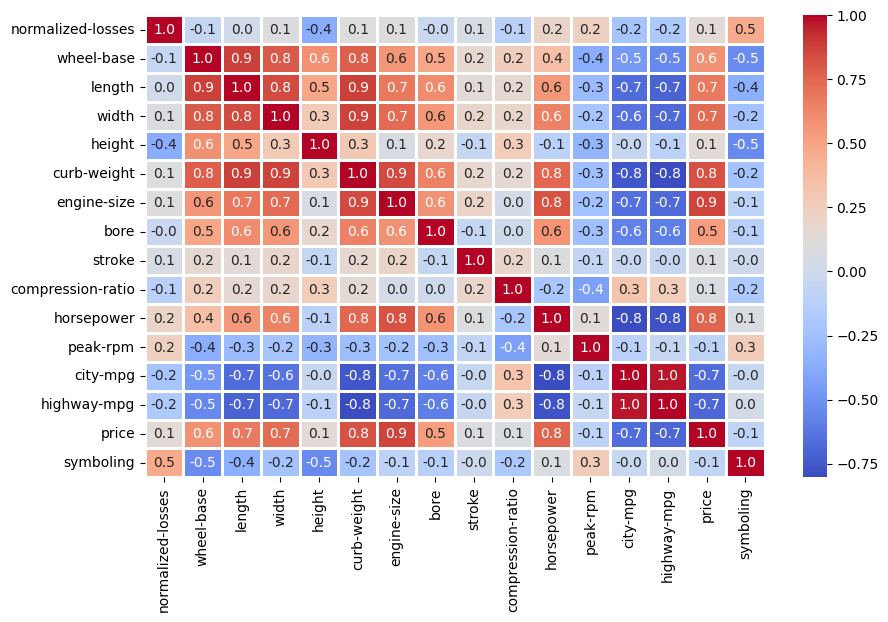

In [8]:
# Imprime matriz de correclacion
corr = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, square=False,  annot_kws={"size": 10}, annot=True, linewidths=.95, fmt='.1f', cmap='coolwarm')

datos = np.array(df)

attPred = [12,14] #12 mpg-highway y 14 precio  #-- nro de atributos a predecir
T = datos[:, attPred]
X = np.delete(datos, attPred, 1) # elimina columnas de atributos a predecir

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_test, y_train, y_test = train_test_split(X, T, test_size = 0.2,  shuffle = True)

data_scaler, target_scaler = StandardScaler(), StandardScaler()
x_train = data_scaler.fit_transform(x_train)
x_test = data_scaler.transform(x_test)
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

**Construccion del modelo y entrenamiento del modelo con parada temprana**

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Habilitar eager execution para eviar warnings
#tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

# Tu código para cargar los datos y dividirlos en conjuntos de entrenamiento y validación
EPOCAS = 1000
TAM_LOTE = 32
ENTRADAS = X.shape[1]
SALIDAS = len(attPred)
PACIENCIA = 12
NUM_ENTRENAMIENTOS = 5  # Número de veces que se entrena cada modelo

#ACTIVACION  = 'relu'
#ACTIVACION  = 'sigmoid'
ACTIVACION  = 'tanh'
#ACTIVACION  = LeakyReLU(alpha=0.01)




early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

epocas = []
medida_train = []

# normalizadores para caracterirsitcas de entrenamiento y caracteristica a predecir
data_scaler, target_scaler = StandardScaler(), StandardScaler()

for i in range(NUM_ENTRENAMIENTOS):

    # Reorganiza al azar datos de entrenamiento
    x_train, x_test, y_train, y_test = train_test_split(X, T, test_size = 0.2,  shuffle = True)


    x_train = data_scaler.fit_transform(x_train)
    x_test = data_scaler.transform(x_test)
    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    print('\r      Train %2d/%2d' % (i+1, NUM_ENTRENAMIENTOS), end='')
    model = Sequential()
    model.add(Input(shape=(ENTRADAS,))),
    model.add(Dense(8, activation=ACTIVACION))
    model.add(Dense(4, activation=ACTIVACION))
    model.add(Dense(SALIDAS))



    OPTIMIZADOR = SGD(learning_rate=0.01)
    #OPTIMIZADOR = RMSprop(learning_rate=0.01)
    #OPTIMIZADOR = Adam(learning_rate=0.01)

    model.compile(optimizer=OPTIMIZADOR, loss='mae', metrics=['mse', 'mae'])

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=TAM_LOTE,
        epochs=EPOCAS,
        validation_data=(x_test, y_test),
        callbacks=[early_stop],
        verbose=0
    )

    epocas.append(len(history.epoch))
    y_pred = model.predict(x_train, verbose=0)
    r2_train = r2_score(y_train, y_pred)
    medida_train.append(r2_train)

    print(' -> epocas: %3d | r2: %7.5f' % (epocas[-1], medida_train[-1]))

promedios = (np.mean(epocas), np.mean(medida_train))
#resumen[(ACTIVACION, OPTIMIZADOR)] = promedios
print('\nProm => epocas: %4d | r2: %7.5f\n' % promedios)


      Train  1/ 5 -> epocas: 277 | r2: 0.79589
      Train  2/ 5 -> epocas:  12 | r2: -0.01608
      Train  3/ 5WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000145958EDB20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
 -> epocas:  12 | r2: -0.65452
      Train  4/ 5WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_s

**Gráficos con evolución de curvas de error y accuracy**

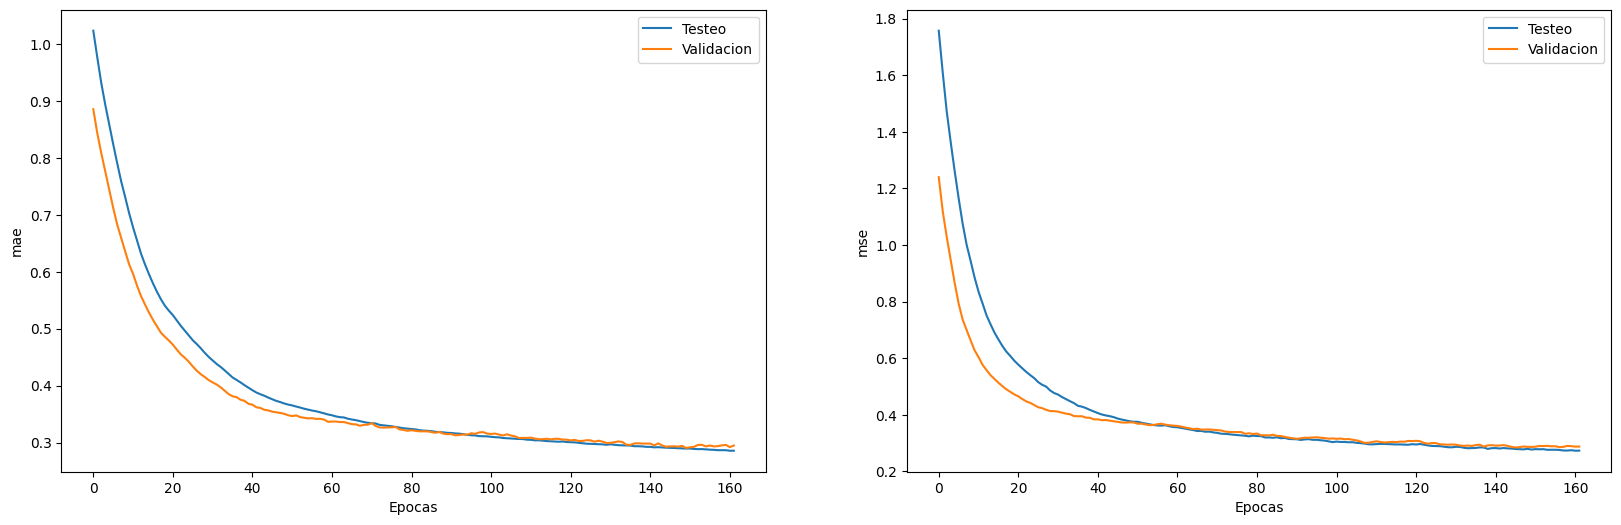

In [32]:
def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,2, figsize=(20,6))

dibujar_curva(axs[0], 'mae', history.epoch, history.history)
dibujar_curva(axs[1], 'mse', history.epoch, history.history)

**Retroalimentación visual de las predicciones sobre los datos de validación**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


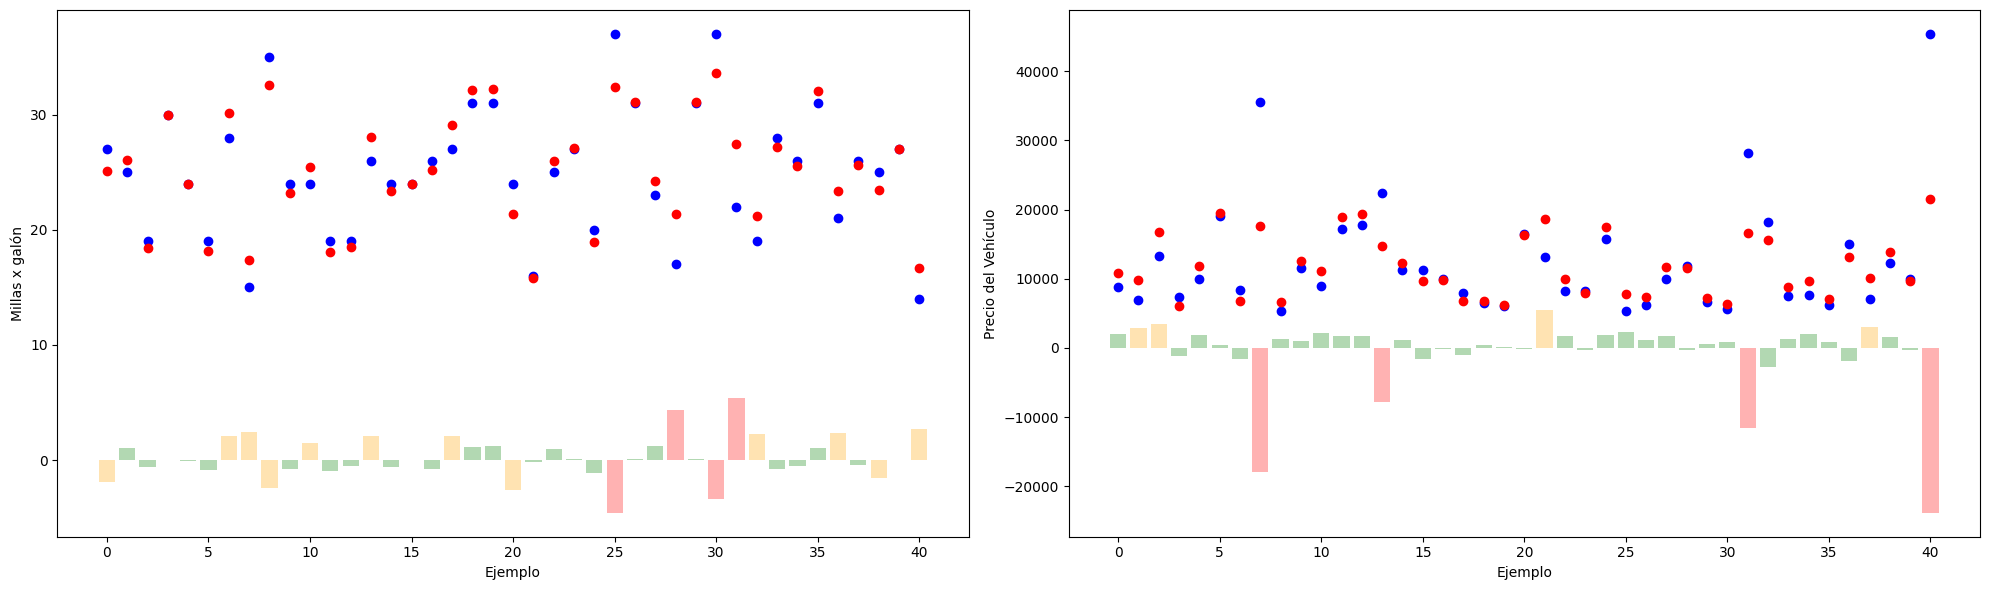

MPG - Error absoluto promedio: 1.44
MPG - Error máximo: 5.42

Precio - Error absoluto promedio: $2862.76
Precio - Error máximo: $23835.03


In [33]:
y_pred = model.predict(x_test)

y_test_no_norm = target_scaler.inverse_transform(y_test)
y_pred_no_norm = target_scaler.inverse_transform(y_pred)

diff_mpg = y_pred_no_norm[:,0] - y_test_no_norm[:,0]
diff_price = y_pred_no_norm[:,1] - y_test_no_norm[:,1]

sample = list(range(len(y_test_no_norm)))

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# MPG
# Grafica barras con diferencia verde < promedio, naranja < 2*promedio, rojo > 2*promedio
colors_mpg = ['green' if abs(e) < abs(diff_mpg).mean() else 'orange' if abs(e) < 2*abs(diff_mpg).mean() else 'red' for e in diff_mpg]
axs[0].bar(sample, diff_mpg, color=colors_mpg, alpha=0.3)
# Grafica puntos valores predichos y valores a predecir
axs[0].plot(sample, y_test_no_norm[:,0], "o", color='blue')
axs[0].plot(sample, y_pred_no_norm[:,0], "o", color='red')
axs[0].set(xlabel='Ejemplo', ylabel='Millas x galón')

# Precio
# Grafica barras con diferencia verde < promedio, naranja < 2*promedio, rojo > 2*promedio
colors_price = ['green' if abs(e) < abs(diff_price).mean() else 'orange' if abs(e) < 2*abs(diff_price).mean() else 'red' for e in diff_price]
axs[1].bar(sample, diff_price, color=colors_price, alpha=0.3)
# Grafica puntos valores predichos y valores a predecir
axs[1].plot(sample, y_test_no_norm[:,1], "o", color='blue')
axs[1].plot(sample, y_pred_no_norm[:,1], "o", color='red')
axs[1].set(xlabel='Ejemplo', ylabel='Precio del Vehículo')

plt.tight_layout()
plt.show()
print(f"MPG - Error absoluto promedio: {abs(diff_mpg).mean():.2f}")
print(f"MPG - Error máximo: {abs(diff_mpg).max():.2f}")
print(f"\nPrecio - Error absoluto promedio: ${abs(diff_price).mean():.2f}")
print(f"Precio - Error máximo: ${abs(diff_price).max():.2f}")